<a href="https://colab.research.google.com/github/kenny08gt/proyecto_statistical_learning2/blob/master/ProyectoSL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/statistical learning 2/Proyecto/pmsm_temperature_data.csv')
data.describe()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-0.003905,0.004723,0.004780,-0.005690,-0.006336,-0.003333,0.006043,-0.003194,-0.004396,0.000609,-0.002208,-0.003935,50.732001
std,0.993127,1.002423,0.997878,1.002330,1.001229,0.997907,0.998994,0.997912,0.995686,1.001049,0.999597,0.998343,22.073125
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973,4.000000
25%,-0.599385,-1.037925,-0.826359,-0.927390,-0.951892,-0.266917,-0.756296,-0.257269,-0.672308,-0.747265,-0.761951,-0.725622,32.000000
50%,0.266157,-0.177187,0.267542,-0.099818,-0.140246,-0.187246,0.213935,-0.190076,0.094367,-0.057226,0.005085,0.006536,56.000000
75%,0.686675,0.650709,0.358491,0.852625,0.853584,0.547171,1.013975,0.499260,0.680691,0.697344,0.772239,0.725660,68.000000
max,2.967117,2.649032,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781,81.000000


* **ambient**: Ambient temperature as measured by a thermal sensor located closely to the stator.
* **coolant**: Coolant temperature. The motor is water cooled. Measurement is taken at outflow.
* **u_d**: Voltage d-component
* **u_q**: Voltage q-component
* **motor_speed**: Motor speed
* **torque**: Torque induced by current.
* **i_d**: Current d-component
* **i_q**: Current q-component
* **pm**: Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared thermography unit.
* **stator_yoke**: Stator yoke temperature measured with a thermal sensor.
* **stator_tooth**: Stator tooth temperature measured with a thermal sensor.
* **stator_winding**: Stator winding temperature measured with a thermal sensor.
* **profile_id**:  Each measurement session has a unique ID. Make sure not to try to estimate from one session onto the other as they are strongly independent.

In [2]:
nans=pd.isnull(data).sum()
nans[nans>0]

Series([], dtype: int64)

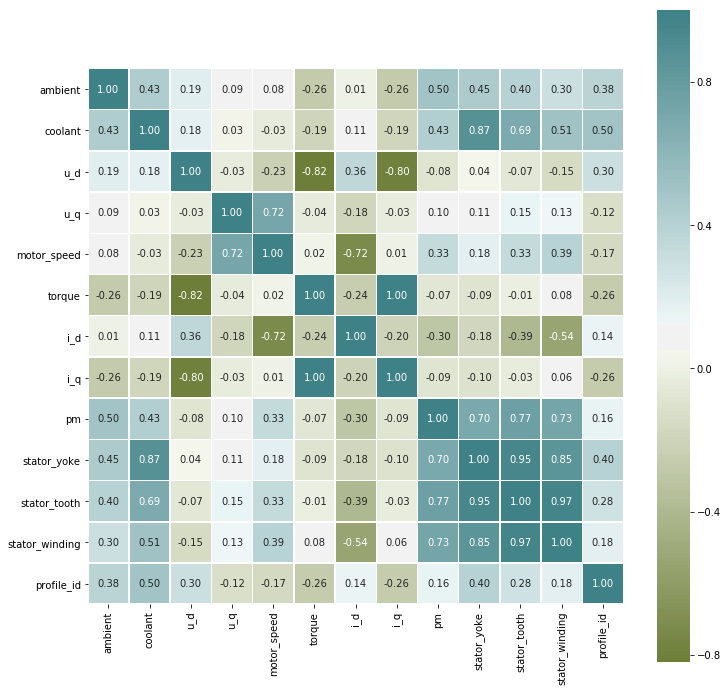

In [3]:
#correlation map
f,ax=plt.subplots(figsize=(12,12))
corr=data.corr()

sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', mask= np.zeros_like(corr,dtype=np.bool), cmap=sns.diverging_palette(100,200,as_cmap=True), 
            square=True, ax=ax)

plt.show()

In [4]:
data = data.drop(columns=['profile_id'])
data.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
x = data[['stator_yoke','stator_tooth', 'stator_winding', 'coolant', 'ambient']].to_numpy()
y = data['pm'].to_numpy()
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 345)

x_train = torch.FloatTensor(xTrain).cuda()
y_train = torch.FloatTensor(yTrain).cuda()
x_test = torch.FloatTensor(xTest).cuda()
y_test = torch.FloatTensor(yTest).cuda()

In [0]:
class Feedforward(torch.nn.Module):
  def __init__(self, input_size, hidden_size):
    super(Feedforward, self).__init__()
    self.input_size = input_size
    self.hidden_size  = hidden_size
    self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
    self.relu = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size - 2)
    self.fc3 = torch.nn.Linear(self.hidden_size - 2, 1)
    self.sigmoid = torch.nn.Sigmoid()
  def forward(self, x):
    hidden = self.fc1(x)
    relu = self.relu(hidden)
    hidden2 = self.fc2(relu)
    relu2 = self.relu(hidden2)
    output =self.fc3(relu2)
    output = self.sigmoid(output)
    return output

In [0]:
# # print(torch.cuda.is_available())

# def get_default_device():
#   if torch.cuda.is_available():
#     return torch.device('cuda')
#   else:
#     return torch.device('cpu')
# def to_device(data, device):
#   if isinstance(data, (list, tuple)):
#     return [to_device(x, device) for x in data]
#   return data.to(device, non_blocking = True)

# class DeviceDataLoader():
#   def __init__(self, dl, device):
#     self.shape = dl.shape
#     self.dl = dl
#     self.device = device
    
#   def __iter__(self):
#     for b in self.dl:
#       yield to_device(b, self.device)

      
#   def __len__(self):
#     return len(self.dl)
  
#   def __dim__(self):
#     return self.shape
  
#   def dim(self):
#     print(self.dl)
#     return self.shape

# device = get_default_device()

# x_train = DeviceDataLoader(x_train, device);
# y_train = DeviceDataLoader(y_train, device);
# x_test = DeviceDataLoader(x_test, device);
# y_test = DeviceDataLoader(y_test, device);

In [0]:
model = Feedforward(5, 20)
model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.5)

model.train()
epoch = 20000
for epoch in range(epoch):
  optimizer.zero_grad()
  # Forward pass
  y_pred = model(x_train)
  # Compute Loss
  loss = criterion(y_pred.squeeze(), y_train)

  if epoch % 100 == 0:
      print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
  # Backward pass
  loss.backward()
  optimizer.step()
    
print('**************************')
model.eval()
y_pred = model(x_test)
after_train = criterion(y_pred.squeeze(), y_test) 
print('Test loss after Training' , after_train.item())

r_square = r2_score(y_test, y_pred.detach().numpy().squeeze())
print('R^2 '+ str(r_square))

Epoch 0: train loss: 1.3336321115493774
Epoch 100: train loss: 0.7479813694953918
Epoch 200: train loss: 0.713636040687561
Epoch 300: train loss: 0.7061668634414673
Epoch 400: train loss: 0.70316082239151
Epoch 500: train loss: 0.7011402249336243
Epoch 600: train loss: 0.6994255781173706
Epoch 700: train loss: 0.6978166699409485
Epoch 800: train loss: 0.6962572336196899
Epoch 900: train loss: 0.6947082877159119
Epoch 1000: train loss: 0.6931437253952026
Epoch 1100: train loss: 0.6915406584739685
Epoch 1200: train loss: 0.6898753643035889
Epoch 1300: train loss: 0.6881504654884338
Epoch 1400: train loss: 0.6863749623298645
Epoch 1500: train loss: 0.684539258480072
Epoch 1600: train loss: 0.6826427578926086
Epoch 1700: train loss: 0.6806790232658386
Epoch 1800: train loss: 0.6787664294242859
Epoch 1900: train loss: 0.6769595146179199
Epoch 2000: train loss: 0.6752702593803406
Epoch 2100: train loss: 0.67372065782547
Epoch 2200: train loss: 0.6723264455795288
Epoch 2300: train loss: 0.671